In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from imgcube.cube import imagecube
import numpy as np
import emcee 
import corner
import celerite

In [10]:
# Load data and calculate RMS from Jy/beam > K.
cube = imagecube('../data/TWHya.290GHz.40mas.fits', clip=1.0, kelvin=True)
rms = cube._jybeam_to_Tb_RJ(20e-6)

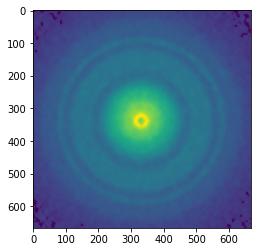

In [11]:
# Check data.
fig, ax = plt.subplots()
ax.imshow(cube.data)

In [16]:
def lnprob(theta):
    """Log-probability function."""
    
    # Unpacking.
    x0, y0, inc, PA, lnrms, lnrho, lnsigma = theta
    
    # Log-priors.
    if abs(x0) >= 0.1:
        return -np.inf
    if abs(y0) >= 0.1:
        return -np.inf
    if not 0.0 < inc < 15.0:
        return -np.inf
    if not abs(lnrms) < 5:
        return -np.inf
    if not abs(lnrho) < 21.:
        return -np.inf
    if not abs(lnsigma) < 21.:
        return -np.inf
    
    # Gaussian prior on PA from fitting CO emission.
    lnp = np.exp(-0.5 * np.power((151.11 - PA) / 1.5, 2.0))
    lnp = np.log(lnp / np.sqrt(2. * np.pi) / 1.5)
    
    # Deproject the data.
    x = cube.disk_coords(x0=x0, y0=y0, inc=inc, PA=PA)[0].flatten()
    y = cube.data.flatten()
    
    # Sort the pixels and remove any negative values.
    
    #x, y = x[::10], y[::10]
    
    idx = np.argsort(x)
    x, y = x[idx], y[idx]
    idx = y > 0.0
    x, y = x[idx], y[idx]
    
    # Build the GP kernel.
    k_jitter = celerite.terms.JitterTerm(log_sigma=lnrms)
    k_line = celerite.terms.Matern32Term(log_sigma=lnsigma, log_rho=lnrho)
    gp = celerite.GP(k_jitter + k_line,
                     mean=np.nanmean(cube.data), fit_mean=True)
    try:
        gp.compute(x, yerr=0.493*np.ones(x.size))
    except Exception:
        return -np.inf
    
    # Calculate the log-likelihood.
    ll = gp.log_likelihood(y, quiet=True)
    return lnp + ll if np.isfinite(ll) else -np.inf

In [ ]:
scatter = 3e-3
nwalkers = 16
nburnin = 100
nsteps = 100

p0 = np.array([0.0084, 0.005, 5.0, 148., -3.7, -1.65, 2.32])
dp0 = np.random.randn(nwalkers * len(p0)).reshape(nwalkers, len(p0))
dp0 = np.where(p0 == 0.0, 1.0, p0)[None, :] * (1.0 + scatter * dp0)
p0 = np.where(p0[None, :] == 0.0, dp0 - 1.0, dp0)

sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], lnprob)
sampler.run_mcmc(p0, nburnin + nsteps)
samples = sampler.chain[:, -nsteps:]
samples = samples.reshape(-1, samples.shape[-1])

#print("Mean autocorrelation time: {0:.3f} steps"
#      .format(np.mean(sampler.get_autocorr_time())))

labels = [r'$x_0~({\rm mas})$', r'$y_0~({\rm mas})$',
          r'$i~({\rm deg})$', r'${\rm PA}~({\rm deg})$',
          r'$\ln \sigma^2$', r'$\ln \rho$', r'$\ln \sigma$']

for s, sample in enumerate(sampler.chain.T):
    _, ax = plt.subplots()
    for walker in sample.T:
        ax.plot(walker, alpha=0.1, color='k')
    ax.set_xlabel('Steps')
    ax.set_ylabel(labels[s])
    ax.axvline(nburnin, ls=':', color='k')

samples_temp = sampler.chain[:, -nburnin:]
samples_temp = samples_temp.reshape(-1, samples_temp.shape[-1])
samples_temp[:, :2] *= 1e3

fig = corner.corner(samples_temp, quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, labels=labels)

In [ ]:
#np.save('B6_cont.npy', sampler.chain)

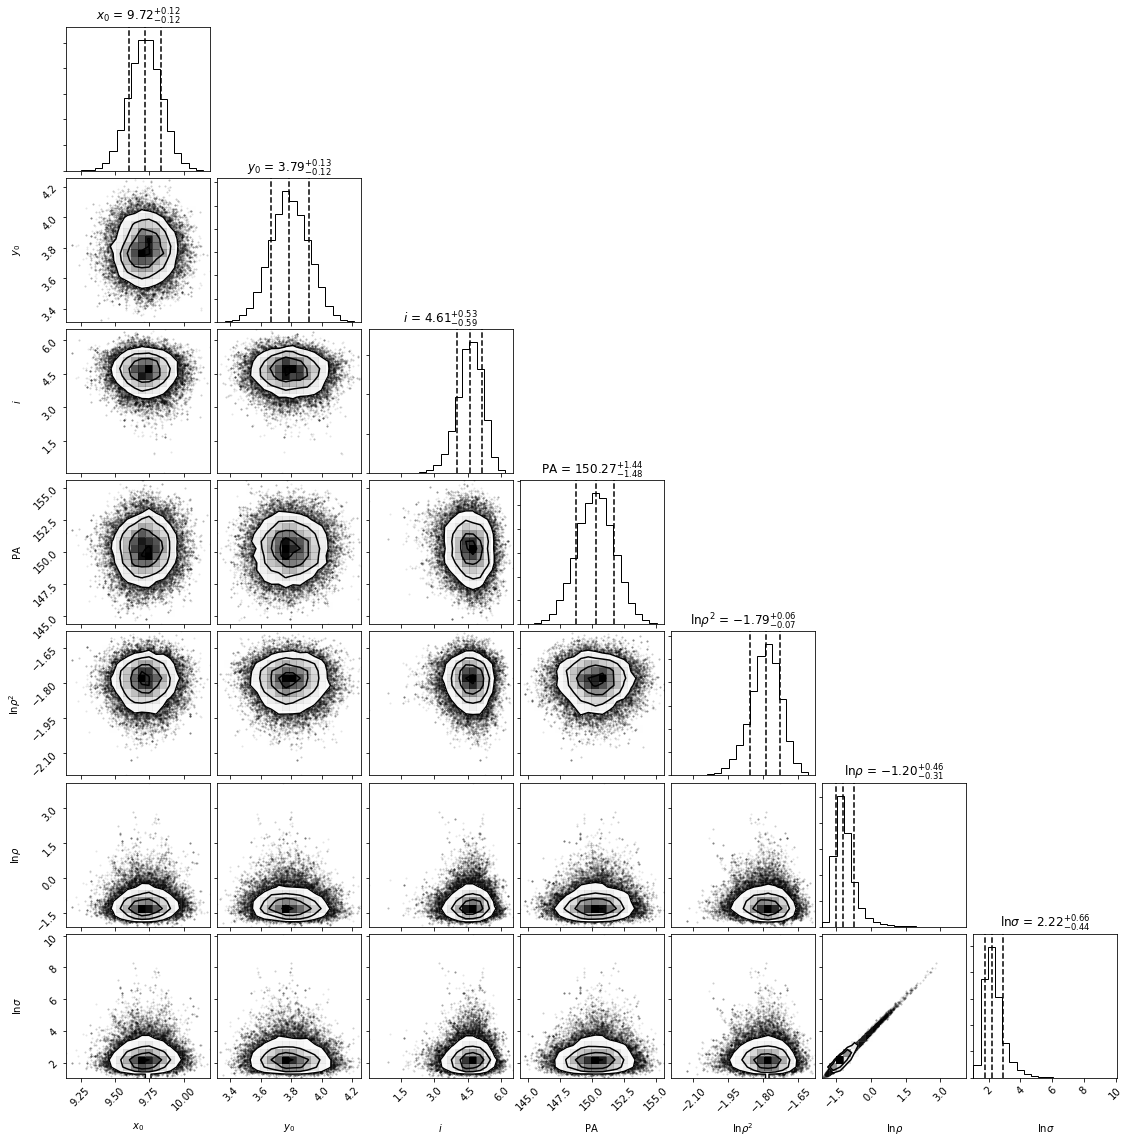

In [9]:
samples_temp = sampler.chain[:, 1000:]
samples_temp = samples_temp.reshape(-1, samples_temp.shape[-1])
samples_temp[:, :2] *= 1e3

fig = corner.corner(samples_temp, quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, labels=labels)